In [1]:
import PyDAQmx
from PyDAQmx import *
from PyDAQmx.DAQmxCallBack import *
from PyDAQmx.DAQmxTypes import *
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

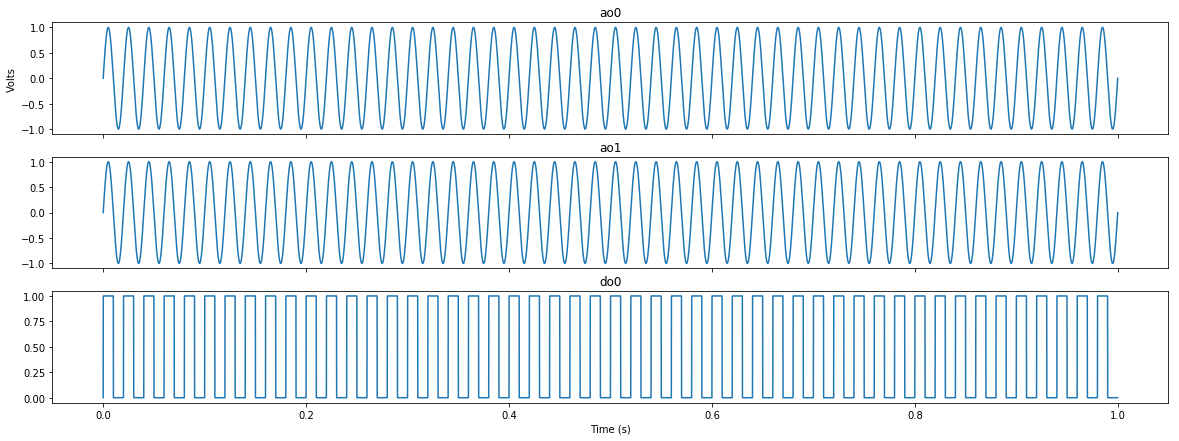

In [3]:
def generate_signal():
    period = 1
    ao_rate = 250000 # Maximum analog output rate for the NI USB-6211 is 250 kHz.
    t = np.arange(0, period, 1/ao_rate)
    frequency = 50
    sinewave =  np.sin(frequency*(t*(2*np.pi)))
    writeArray = np.concatenate((sinewave, sinewave))
    
    s = {'t': t, 'analog_writeArray' : writeArray, 
              'ao0': sinewave, 
              'ao1': sinewave,
             }

    binary_switch = (sinewave>0).astype(np.uint8)
    s['do0'] = binary_switch
    s['do1'] = binary_switch
    s['do2'] = binary_switch
    s['do3'] = binary_switch
    s['digital_writeArray'] = np.concatenate((s['do0'], s['do1'], s['do2'], s['do3']))
    return s

def plot_signal(signal):
    fig, (ax0, ax1, ax2) = plt.subplots(3, 1, sharex=True, figsize=(20, 7))
    t = signal['t']
    ao0 = signal['ao0']
    ao1 = signal['ao1']
    do0 = signal['do0']
    ax0.plot(t, ao0)
    ax1.plot(t, ao1)
    ax2.plot(t, do0)
    ax0.set_title('ao0')
    ax1.set_title('ao1')
    ax2.set_title('do0')
    ax2.set_xlabel('Time (s)')
    ax0.set_ylabel('Volts')

signal = generate_signal()
plot_signal(signal)

# Analog Output

In [4]:
def create_task():
    ao = Task()
    ao.CreateAOVoltageChan("Dev3/ao0", '', -10.0, 10.0, DAQmx_Val_Volts, None)
    ao.CreateAOVoltageChan("Dev3/ao1", '', -10.0, 10.0, DAQmx_Val_Volts, None)
    return ao
pointer = int32()

def setup_task(ao, writeArray):
    ao_rate = 250000 # Maximum analog output rate for the NI USB-6211 is 250 kHz.
    sampsPerPeriod = int(len(writeArray)/2)
    ao.CfgSampClkTiming('', ao_rate, DAQmx_Val_Rising, DAQmx_Val_ContSamps, sampsPerPeriod)   # CfgSampClkTiming(source, rate, activeEdge, sampleMode, sampsPerChan)
 #  WriteAnalogF64(numSampsPerChan, autoStart, timeout, dataLayout, writeArray, sampsPerChanWritten, reserved)
    ao.WriteAnalogF64(sampsPerPeriod, 0, -1, DAQmx_Val_GroupByChannel, writeArray, byref(pointer), None) 
    ao.StartTask()
    return ao

In [5]:
signal = generate_signal()
writeArray = signal['analog_writeArray']

In [6]:
ao = create_task()

In [7]:
ao = setup_task(ao, writeArray)

In [8]:
ao.StopTask()

In [10]:
pointer

c_long(250000)

# Digital Output

In [16]:
def create_digital_task():
    do = Task()
    do.CreateDOChan("Dev1/port1/line0:3", "", PyDAQmx.DAQmx_Val_ChanForAllLines)
    return do

In [17]:
def setup_digital_task(do, writeArray):
    do_rate = 250000 # Maximum analog output rate for the NI USB-6211 is 250 kHz.
    sampsPerPeriod = int(len(writeArray)/4)
    #do.CfgSampClkTiming('', do_rate, DAQmx_Val_Rising, DAQmx_Val_ContSamps, sampsPerPeriod)   # CfgSampClkTiming(source, rate, activeEdge, sampleMode, sampsPerChan)
 #  WriteDigitalLines(numSampsPerChan, autoStart, timeout, dataLayout, writeArray, sampsPerChanWritten, reserved)
    do.WriteDigitalLines(sampsPerPeriod, 1, -1, PyDAQmx.DAQmx_Val_GroupByChannel, writeArray, None, None)
    do.StartTask()
    return do

In [18]:
signal = generate_signal()
writeArray = signal['digital_writeArray']

In [19]:
do = create_digital_task()

In [20]:
do.CfgSampClkTiming?

Signature: do.CfgSampClkTiming(source, rate, activeEdge, sampleMode, sampsPerChan)
Docstring: T.CfgSampClkTiming(source, rate, activeEdge, sampleMode, sampsPerChan) -> error.
File:      Dynamically generated function. No source code available.
Type:      method


In [33]:
setup_digital_task(do, writeArray)

Task number 1443490674192

In [34]:
do.StopTask()